In [1]:
# ! conda install -y gdown
!gdown --id 1ovYiBl-6XFBI9ooATficyPpY6aaZCYEk

Downloading...
From: https://drive.google.com/uc?id=1ovYiBl-6XFBI9ooATficyPpY6aaZCYEk
To: /content/Dataset 1.csv
100% 999k/999k [00:00<00:00, 66.2MB/s]


In [2]:
import pandas as pd

In [3]:
import torch   

#handling text data
from torchtext.legacy import data  

In [4]:
dataset=pd.read_csv('/content/Dataset 1.csv',encoding='ISO-8859-1')

In [5]:
import re
def remove(text):
    return re.sub(r"[,.\"!@#$%^&*(){}?/;`~:<>+=-]", "", text)


In [6]:
dataset['message'] = dataset['message'].apply(lambda x: remove(x))


In [7]:
dataset

,message,label
0,just had a real good moment i missssssssss him...,0
1,is reading manga httpplurkcompmzp1e,0
2,comeagainjen httptwitpiccom2y2lx httpwwwyoutu...,0
3,lapcat Need to send 'em to my accountant tomor...,0
4,ADD ME ON MYSPACE myspacecomLookThunder,0
...,...,...
10309,No Depression by G Herbo is my mood from now o...,1
10310,What do you do when depression succumbs the br...,1
10311,Ketamine Nasal Spray Shows Promise Against Dep...,1
10312,dont mistake a bad day with depression everyon...,1


In [8]:
dataset.drop(10313,inplace=True)

In [9]:
dataset.rename(columns = {'message':'text'}, inplace = True)

In [11]:
dataset

,text,label
0,just had a real good moment i missssssssss him...,0
1,is reading manga httpplurkcompmzp1e,0
2,comeagainjen httptwitpiccom2y2lx httpwwwyoutu...,0
3,lapcat Need to send 'em to my accountant tomor...,0
4,ADD ME ON MYSPACE myspacecomLookThunder,0
...,...,...
10308,Many sufferers of depression aren't sad they f...,1
10309,No Depression by G Herbo is my mood from now o...,1
10310,What do you do when depression succumbs the br...,1
10311,Ketamine Nasal Spray Shows Promise Against Dep...,1


In [12]:
dataset.drop( dataset[dataset.text.str.len() < 5].index, inplace=True)

In [13]:
dataset.to_csv('data.csv',index=False)

In [14]:
#Reproducing same results
SEED = 2019

#Torch
torch.manual_seed(SEED)

#Cuda algorithms
torch.backends.cudnn.deterministic = True  

TEXT = data.Field(tokenize='spacy',batch_first=True,include_lengths=True)
LABEL = data.LabelField(dtype = torch.float,batch_first=True)

fields = [('text',TEXT),('label', LABEL)]

In [15]:
#loading custom dataset
training_data=data.TabularDataset(path = 'data.csv',format = 'csv',fields = fields,skip_header = True)

#print preprocessed text
print(vars(training_data.examples[2]))

{'text': ['comeagainjen', 'httptwitpiccom2y2lx', ' ', 'httpwwwyoutubecomwatchvzoGfqvh2ME8'], 'label': '0'}


In [16]:
import random
train_data, valid_data = training_data.split(split_ratio=0.7, random_state = random.seed(SEED))

In [17]:
#initialize glove embeddings
TEXT.build_vocab(train_data,min_freq=3,vectors = "glove.6B.100d")  
LABEL.build_vocab(train_data)

#No. of unique tokens in text
print("Size of TEXT vocabulary:",len(TEXT.vocab))

#No. of unique tokens in label
print("Size of LABEL vocabulary:",len(LABEL.vocab))

#Commonly used words
print(TEXT.vocab.freqs.most_common(10))  

#Word dictionary
print(TEXT.vocab.stoi)   

.vector_cache/glove.6B.zip: 862MB [02:43, 5.28MB/s]                           
100%|█████████▉| 399999/400000 [00:17<00:00, 23170.19it/s]


Size of TEXT vocabulary: 3605
Size of LABEL vocabulary: 2
[(' ', 3416), ('I', 2710), ('to', 2605), ('the', 2399), ('a', 2107), ('and', 1793), ('you', 1605), ('depression', 1269), ('of', 1252), ('it', 1204)]
defaultdict(<bound method Vocab._default_unk_index of <torchtext.legacy.vocab.Vocab object at 0x7f17b1b80fd0>>, {'<unk>': 0, '<pad>': 1, ' ': 2, 'I': 3, 'to': 4, 'the': 5, 'a': 6, 'and': 7, 'you': 8, 'depression': 9, 'of': 10, 'it': 11, 'is': 12, 'my': 13, 'for': 14, 'i': 15, 'in': 16, "'s": 17, 'that': 18, 'with': 19, 'on': 20, 'me': 21, 'have': 22, "n't": 23, 'so': 24, "'m": 25, 'do': 26, 'be': 27, 'your': 28, 'was': 29, '\xa0': 30, 'are': 31, 'just': 32, 'but': 33, 'this': 34, 'not': 35, 'at': 36, 'out': 37, 'good': 38, 'like': 39, 'all': 40, 'day': 41, 'about': 42, 'up': 43, 'love': 44, 'can': 45, '¦': 46, 'from': 47, 'get': 48, 'now': 49, 'Depression': 50, 'Ã¢Â\x80Â': 51, 'know': 52, "'": 53, '  ': 54, 'time': 55, 'what': 56, 'or': 57, 'today': 58, 'will': 59, 'one': 60, 'go': 

In [18]:
#check whether cuda is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  

#set batch size
BATCH_SIZE = 64

#Load an iterator
train_iterator, valid_iterator = data.BucketIterator.splits(
    (train_data, valid_data), 
    batch_size = BATCH_SIZE,
    sort_key = lambda x: len(x.text),
    sort_within_batch=True,
    device = device)

In [19]:
import torch.nn as nn

class classifier(nn.Module):
    
    #define all the layers used in model
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout):
        
        #Constructor
        super().__init__()          
        
        #embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        #lstm layer
        self.lstm = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           bidirectional=bidirectional, 
                           dropout=dropout,
                           batch_first=True)
        
        #dense layer
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        
        #activation function
        self.act = nn.Sigmoid()
        
    def forward(self, text, text_lengths):
        
        #text = [batch size,sent_length]
        embedded = self.embedding(text)
        #embedded = [batch size, sent_len, emb dim]
      
        #packed sequence
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths,batch_first=True)
        
        packed_output, (hidden, cell) = self.lstm(packed_embedded)
        #hidden = [batch size, num layers * num directions,hid dim]
        #cell = [batch size, num layers * num directions,hid dim]
        
        #concat the final forward and backward hidden state
        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)
                
        #hidden = [batch size, hid dim * num directions]
        dense_outputs=self.fc(hidden)

        #Final activation function
        outputs=self.act(dense_outputs)
        
        return outputs

In [20]:
#define hyperparameters
size_of_vocab = len(TEXT.vocab)
embedding_dim = 100
num_hidden_nodes = 32
num_output_nodes = 1
num_layers =3
bidirection = True
dropout = 0.2

#instantiate the model
model = classifier(size_of_vocab, embedding_dim, num_hidden_nodes,num_output_nodes, num_layers, 
                   bidirectional = True, dropout = dropout)

In [21]:
import torch.optim as optim

#define optimizer and loss
optimizer = optim.Adam(model.parameters())
criterion = nn.BCELoss()

#define metric
def binary_accuracy(preds, y):
    #round predictions to the closest integer
    rounded_preds = torch.round(preds)
    
    correct = (rounded_preds == y).float() 
    acc = correct.sum() / len(correct)
    return acc
    
#push to cuda if available
model = model.to(device)
criterion = criterion.to(device)

In [22]:
model

classifier(
  (embedding): Embedding(3605, 100)
  (lstm): LSTM(100, 32, num_layers=3, batch_first=True, dropout=0.2, bidirectional=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
  (act): Sigmoid()
)

In [23]:
def train(model, iterator, optimizer, criterion):
    
    #initialize every epoch 
    epoch_loss = 0
    epoch_acc = 0
    
    #set the model in training phase
    model.train()  
    
    for batch in iterator:
        
        #resets the gradients after every batch
        optimizer.zero_grad()   
        
        #retrieve text and no. of words
        text, text_lengths = batch.text

        text=text.to(device) 
        text_lengths=torch.as_tensor(text_lengths, dtype=torch.int64, device='cpu') 
         
        
        #convert to 1D tensor
        predictions = model(text, text_lengths).squeeze()  
        
        #compute the loss
        loss = criterion(predictions, batch.label)        
        
        #compute the binary accuracy
        acc = binary_accuracy(predictions, batch.label)   
        
        #backpropage the loss and compute the gradients
        loss.backward()       
        
        #update the weights
        optimizer.step()      
        
        #loss and accuracy
        epoch_loss += loss.item()  
        epoch_acc += acc.item()    
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [24]:
def evaluate(model, iterator, criterion):
    
    #initialize every epoch
    epoch_loss = 0
    epoch_acc = 0

    #deactivating dropout layers
    model.eval()
    
    #deactivates autograd
    with torch.no_grad():
    
        for batch in iterator:
        
            #retrieve text and no. of words
            text, text_lengths = batch.text
            text=text.to(device)
            text_lengths=torch.as_tensor(text_lengths, dtype=torch.int64, device='cpu') 
            #convert to 1d tensor
            predictions = model(text, text_lengths).squeeze()
            
            #compute loss and accuracy
            loss = criterion(predictions, batch.label)
            acc = binary_accuracy(predictions, batch.label)
            
            #keep track of loss and accuracy
            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [25]:
train_losses=[]
valid_losses=[]
train_accuracy=[]
valid_accuracy=[]

N_EPOCHS = 10
best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
     
    #train the model
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    train_losses.append(train_loss)
    train_accuracy.append(train_acc)
    #evaluate the model
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    valid_losses.append(valid_loss)
    valid_accuracy.append(valid_acc)
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

	Train Loss: 0.506 | Train Acc: 78.36%
	 Val. Loss: 0.350 |  Val. Acc: 85.88%
	Train Loss: 0.178 | Train Acc: 93.72%
	 Val. Loss: 0.084 |  Val. Acc: 98.31%
	Train Loss: 0.069 | Train Acc: 98.68%
	 Val. Loss: 0.056 |  Val. Acc: 98.95%
	Train Loss: 0.055 | Train Acc: 98.79%
	 Val. Loss: 0.043 |  Val. Acc: 99.14%
	Train Loss: 0.040 | Train Acc: 99.09%
	 Val. Loss: 0.039 |  Val. Acc: 99.04%
	Train Loss: 0.032 | Train Acc: 99.37%
	 Val. Loss: 0.039 |  Val. Acc: 99.08%
	Train Loss: 0.026 | Train Acc: 99.46%
	 Val. Loss: 0.039 |  Val. Acc: 99.08%
	Train Loss: 0.022 | Train Acc: 99.45%
	 Val. Loss: 0.034 |  Val. Acc: 99.17%
	Train Loss: 0.017 | Train Acc: 99.60%
	 Val. Loss: 0.045 |  Val. Acc: 98.63%
	Train Loss: 0.014 | Train Acc: 99.72%
	 Val. Loss: 0.038 |  Val. Acc: 99.23%


In [26]:
import matplotlib.pyplot as plt


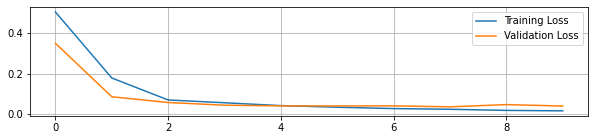

In [27]:
#display stats in graph
plt.figure(figsize=(10, 2))
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.legend()
plt.grid()
plt.show()

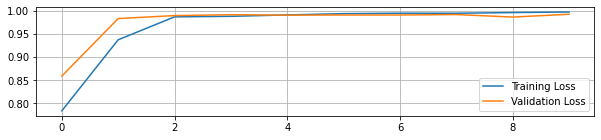

In [28]:
#display stats in graph
plt.figure(figsize=(10, 2))
plt.plot(train_accuracy, label='Training Loss')
plt.plot(valid_accuracy, label='Validation Loss')
plt.legend()
plt.grid()
plt.show()

In [35]:
len(valid_iterator)

49

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [48]:
nb_classes = 2
classes=[0,1]

y_true_tensor = torch.tensor([]).to(device)
y_pred_tensor = torch.tensor([]).to(device)
model.eval()
with torch.no_grad():
    for batch in  valid_iterator:
        text, text_lengths = batch.text
        text=text.to(device)
        text_lengths=torch.as_tensor(text_lengths, dtype=torch.int64, device='cpu')
        predictions = model(text, text_lengths).squeeze()
        rounded_preds = torch.round(predictions)
        
        y_true_tensor = torch.cat((y_true_tensor,batch.label))
        y_pred_tensor = torch.cat((y_pred_tensor,rounded_preds))
        

In [49]:
y_true = y_true_tensor.tolist()
y_pred = y_pred_tensor.tolist()
matrix = confusion_matrix(y_true,y_pred)
matrix

array([[2384,    5],
       [  19,  685]])

In [52]:
classify_report = classification_report(y_true, y_pred)
print(classify_report)

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99      2389
         1.0       0.99      0.97      0.98       704

    accuracy                           0.99      3093
   macro avg       0.99      0.99      0.99      3093
weighted avg       0.99      0.99      0.99      3093



In [43]:
import seaborn as sns

Text(0.5, 24.0, 'Predicted label')

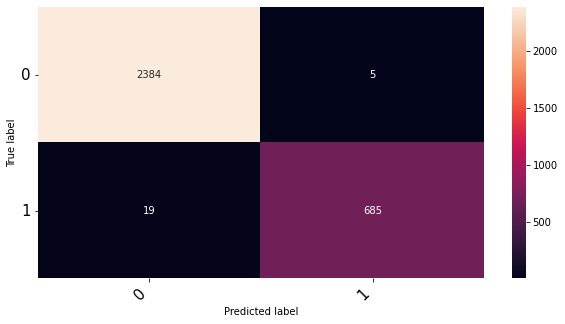

In [53]:
plt.figure(figsize=(10,5))

class_names = ['0','1']
df_cm = pd.DataFrame(matrix, index=class_names, columns=class_names).astype(int)
heatmap = sns.heatmap(df_cm, annot=True, fmt="d")

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=15)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=15)
plt.ylabel('True label')
plt.xlabel('Predicted label')